In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange, tqdm
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
print("Tensorflow version is ", tf.__version__)

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K

cwd = os.getcwd()
print("Current directory is ", cwd)

nd = "/data/McMaster/enclosure_2/enclosure-20-07-10-10-30-51_reformed/"

os.chdir(nd)
cwd = os.getcwd()
print("New current directory is ", cwd)


Tensorflow version is  2.2.0
Current directory is  /data/scripts/Semantic_Segmentation/tf2
New current directory is  /data/McMaster/enclosure_2/enclosure-20-07-10-10-30-51_reformed


In [2]:
# Set some parameters
im_width = 512
im_height = 512
border = 0

count = 1000

In [3]:
ids = next(os.walk("X"))[2][:count] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  1000


In [4]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

#### Load the images and masks into arrays

In [5]:
# tqdm is used to display the progress bar
for n, id_ in tqdm(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("X/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_width, im_height, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("Y/"+id_, grayscale=True))
    mask = resize(mask, (im_width, im_height, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask

  0%|          | 0/1000 [00:00<?, ?it/s]/home/nanotronics/anaconda3/envs/Segkeras/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
100%|██████████| 1000/1000 [00:28<00:00, 35.04it/s]


In [6]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
print("Train shapes: ", X_train.shape, y_train.shape, y_train.dtype)
print("Valid shapes: ", X_valid.shape, y_valid.shape, y_valid.dtype)

Train shapes:  (900, 512, 512, 1) (900, 512, 512, 1) float32
Valid shapes:  (100, 512, 512, 1) (100, 512, 512, 1) float32


#### Below code can be used to visualize the images and corresponding masks

Text(0.5, 1.0, 'Mask')

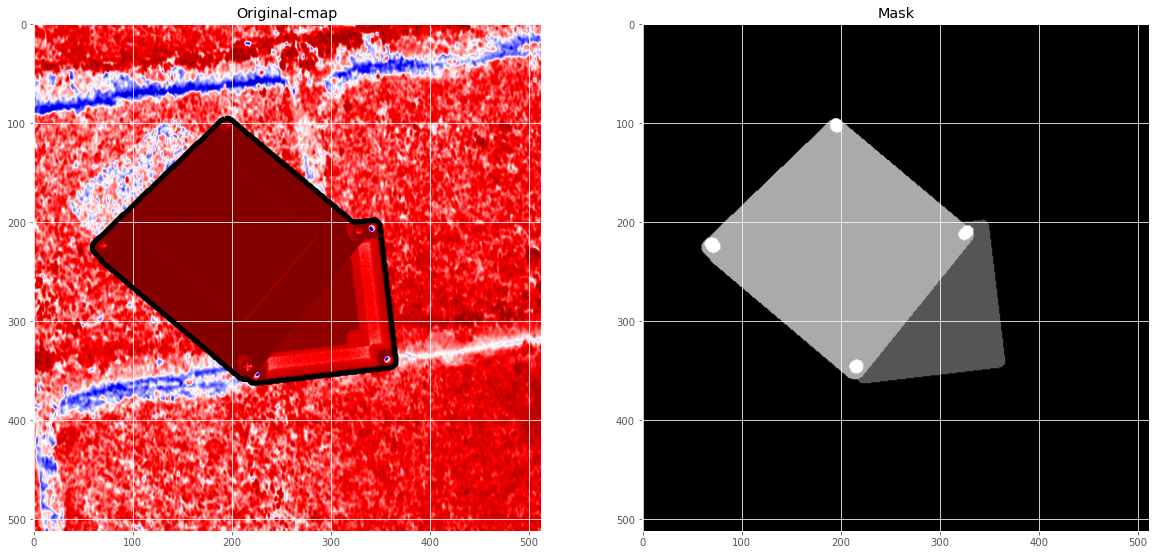

In [7]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Original-cmap')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask')

In [8]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [9]:
def get_unet(im_height, im_width, n_class=4, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    input_img = Input((im_height, im_width, 1), name='img')

    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(n_class, (1, 1), activation='sigmoid')(c9)
    outputs = K.argmax(outputs, axis=-1)
    outputs = K.reshape(outputs, (-1, im_height, im_width, 1) )
    outputs = K.cast(outputs, "float64")
    print(outputs.dtype)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [10]:
model = get_unet(im_height, im_width, n_class=4, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

<dtype: 'float64'>


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 512, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 512, 512, 16) 0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

In [14]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model_aipc_video.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [15]:
results = model.fit(X_train, y_train, batch_size=4, epochs=2, callbacks=callbacks, validation_data=(X_valid, y_valid))

Epoch 1/2


ValueError: in user code:

    /home/nanotronics/anaconda3/envs/Segkeras/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /home/nanotronics/anaconda3/envs/Segkeras/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/nanotronics/anaconda3/envs/Segkeras/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/nanotronics/anaconda3/envs/Segkeras/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/nanotronics/anaconda3/envs/Segkeras/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:541 train_step  **
        self.trainable_variables)
    /home/nanotronics/anaconda3/envs/Segkeras/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1804 _minimize
        trainable_variables))
    /home/nanotronics/anaconda3/envs/Segkeras/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:521 _aggregate_gradients
        filtered_grads_and_vars = _filter_grads(grads_and_vars)
    /home/nanotronics/anaconda3/envs/Segkeras/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:1219 _filter_grads
        ([v.name for _, v in grads_and_vars],))

    ValueError: No gradients provided for any variable: ['conv2d_1/kernel:0', 'conv2d_1/bias:0', 'batch_normalization_1/gamma:0', 'batch_normalization_1/beta:0', 'conv2d_3/kernel:0', 'conv2d_3/bias:0', 'batch_normalization_3/gamma:0', 'batch_normalization_3/beta:0', 'conv2d_5/kernel:0', 'conv2d_5/bias:0', 'batch_normalization_5/gamma:0', 'batch_normalization_5/beta:0', 'conv2d_7/kernel:0', 'conv2d_7/bias:0', 'batch_normalization_7/gamma:0', 'batch_normalization_7/beta:0', 'conv2d_9/kernel:0', 'conv2d_9/bias:0', 'batch_normalization_9/gamma:0', 'batch_normalization_9/beta:0', 'conv2d_transpose/kernel:0', 'conv2d_transpose/bias:0', 'conv2d_11/kernel:0', 'conv2d_11/bias:0', 'batch_normalization_11/gamma:0', 'batch_normalization_11/beta:0', 'conv2d_transpose_1/kernel:0', 'conv2d_transpose_1/bias:0', 'conv2d_13/kernel:0', 'conv2d_13/bias:0', 'batch_normalization_13/gamma:0', 'batch_normalization_13/beta:0', 'conv2d_transpose_2/kernel:0', 'conv2d_transpose_2/bias:0', 'conv2d_15/kernel:0', 'conv2d_15/bias:0', 'batch_normalization_15/gamma:0', 'batch_normalization_15/beta:0', 'conv2d_transpose_3/kernel:0', 'conv2d_transpose_3/bias:0', 'conv2d_17/kernel:0', 'conv2d_17/bias:0', 'batch_normalization_17/gamma:0', 'batch_normalization_17/beta:0', 'conv2d_18/kernel:0', 'conv2d_18/bias:0'].


In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

### Inference

In [ ]:
# load the best model
model.load_weights('model-tgs-salt.h5')

In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

In [ ]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

### Predictions on training set

In [ ]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

### Predictions on test set

In [ ]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=19)

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)